In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from loguru import logger
from pathlib import Path
from scipy import signal

import shap
import librosa
from sklearn.metrics import classification_report
from scipy import signal
import keras
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from keras.layers import Activation, Dense
from sklearn.model_selection import train_test_split
import tensorflow as tf
from ncps.wirings import AutoNCP
from ncps.keras import LTC

/home/aseliverstov/.cache/pypoetry/virtualenvs/brain-signals-_5HxkjSc-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-15 17:30:51.702998: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-15 17:30:51.806123: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-15 17:30:51.911477: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736951451.992563   29020 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00

In [2]:
class EEG:
    def __init__(self, data_dir: Path, intencities: list[float], n_channels: int):
        self.data_dir = data_dir
        self.intencities = intencities
        self.n_channels = n_channels

    def load_participant(self, participant_id: int):
        self.int = {}
        self.delta = {}
        self.theta = {}
        self.alpha = {}
        self.beta = {}
        self.gamma = {}

        for i in self.intencities:
            self.int[i] = np.loadtxt(self.data_dir / f"Participant {participant_id}" / "Figs for spectra" / f"Backgr_int_{i}.dat")
            delta_signal = np.empty(self.int[i].shape)
            theta_signal =  np.empty(self.int[i].shape)
            alpha_signal = np.empty(self.int[i].shape)
            beta_signal = np.empty(self.int[i].shape)
            gamma_signal = np.empty(self.int[i].shape)
            for c in range(self.int[i].shape[1]):
                delta_signal[:, c], theta_signal[:, c], alpha_signal[:, c], beta_signal[:, c], gamma_signal[:, c] = self._fir_filtering(i, c)

            self.delta[i] = delta_signal
            self.theta[i] = theta_signal
            self.alpha[i] = alpha_signal
            self.beta[i] = beta_signal 
            self.gamma[i] = gamma_signal

        participant_info = {}
        participant_info["delta"] = self.delta
        participant_info["theta"] = self.theta
        participant_info["alpha"] = self.alpha
        participant_info["beta"] = self.beta
        participant_info["gamma"] = self.gamma

        return participant_info

    def _fir_filtering(self, i, c):
        filter_delta = signal.firwin(400, [1.0, 4.0], pass_zero=False, fs=250)
        filter_theta = signal.firwin(400, [5.0, 8.0], pass_zero=False, fs=250)
        filter_alpha = signal.firwin(400, [8.0, 12.0], pass_zero=False, fs=250)
        filter_beta = signal.firwin(400, [13.0, 30.0], pass_zero=False, fs=250)
        filter_gamma = signal.firwin(400, [31.0, 45.0], pass_zero=False, fs=250)

        res_delta = signal.convolve(self.int[i][:, c], filter_delta, mode='same')
        res_theta = signal.convolve(self.int[i][:, c], filter_theta, mode='same')
        res_alpha = signal.convolve(self.int[i][:, c], filter_alpha, mode='same')
        res_beta = signal.convolve(self.int[i][:, c], filter_beta, mode='same')
        res_gamma = signal.convolve(self.int[i][:, c], filter_gamma, mode='same')

        return res_delta, res_theta, res_alpha, res_beta, res_gamma

def process_signal_type_participant(dataset: EEG, user: int, signal_type: str):
    eeg_person = dataset.load_participant(user)

    person_signals = []
    signal_index = []
    for i in dataset.intencities:
        for ch in range(dataset.n_channels):
            signal_series = eeg_person[signal_type].get(i)[:, ch][:15000]
            person_signals.append(signal_series)

            signal_index.append([user, i, ch])            

    person_signal_index_df = pd.DataFrame(signal_index, columns=["user", "intensity", "channel"])
    person_signal_index_df["is_left_channel"] = np.where(person_signal_index_df["channel"] % 2 == 0, 1, 0)
    person_signal_index_df["signal_type"] = signal_type

    person_signals_df = pd.DataFrame(person_signals)

    return pd.concat([person_signal_index_df, person_signals_df], axis=1)

In [ ]:
data_dir = Path("./dataset")
intencities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
n_channels = 31
sample_rate = 250

dataset = EEG(data_dir=data_dir, intencities=intencities, n_channels=n_channels)

In [4]:
data = []

for user in [1, 2, 3, 4, 5]:
    for signal_type in ["delta", "theta", "alpha", "beta", "gamma"]:
        data.append(process_signal_type_participant(dataset, user, signal_type))

data = pd.concat(data, axis=0).reset_index(drop=True)

data.head()

,user,intensity,channel,is_left_channel,signal_type,0,1,2,3,4,...,14990,14991,14992,14993,14994,14995,14996,14997,14998,14999
0,1,0.1,0,1,delta,32.819580,22.394499,11.944530,1.509794,-8.869929,...,5.761321,8.584314,11.482307,14.444269,17.451520,20.490840,23.550929,26.612040,29.656919,32.678659
1,1,0.1,1,0,delta,22.895093,22.571077,22.213273,21.817371,21.388242,...,-36.569596,-37.383749,-38.258960,-39.193345,-40.186622,-41.226317,-42.301337,-43.410787,-44.548579,-45.696425
2,1,0.1,2,1,delta,22.636168,25.515590,28.336306,31.081621,33.736376,...,-57.224056,-57.872630,-58.465101,-58.998834,-59.471828,-59.881532,-60.224889,-60.496918,-60.690027,-60.795766
3,1,0.1,3,0,delta,36.106648,38.336931,40.448344,42.426091,44.260684,...,-9.807186,-7.906850,-5.966429,-3.996789,-2.011164,-0.023158,1.954782,3.909010,5.827176,7.701683
4,1,0.1,4,1,delta,26.015135,23.859016,21.597520,19.234030,16.773968,...,-20.737286,-19.244307,-17.681272,-16.058450,-14.386304,-12.677365,-10.941320,-9.185652,-7.417999,-5.644647


# Processing

In [5]:
X = data.iloc[:, 5:].to_numpy()
y = to_categorical((data["intensity"].to_numpy() * 10).astype("int"))[:, 1:]

/home/aseliverstov/.cache/pypoetry/virtualenvs/brain-signals-_5HxkjSc-py3.10/lib/python3.10/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


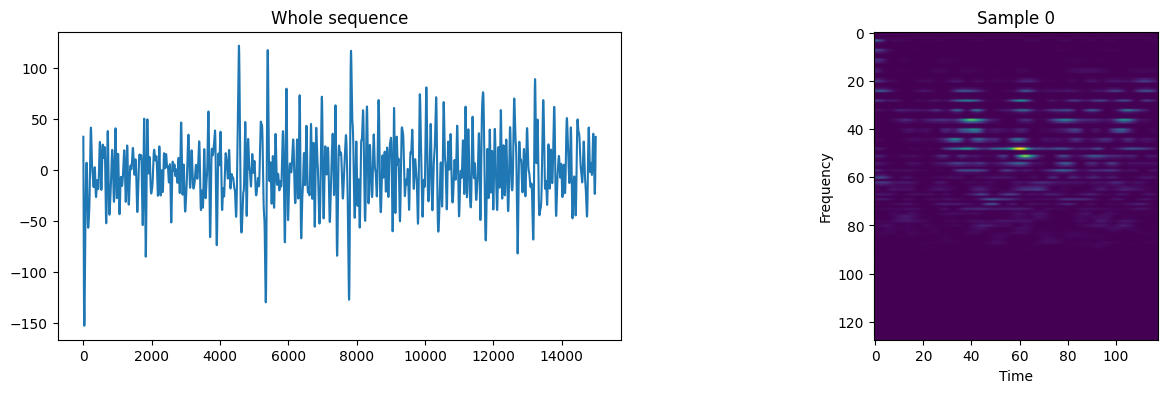

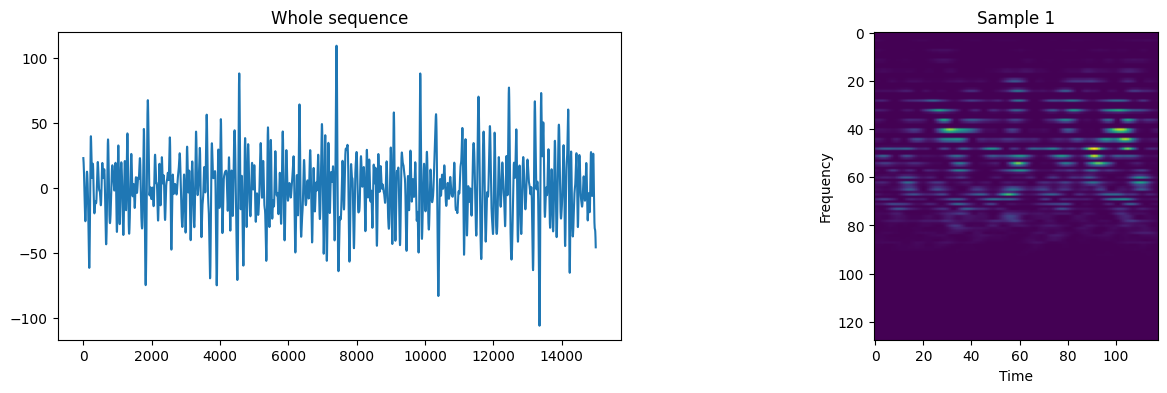

In [6]:
for sample_idx in range(2):
    amplitudes = X[sample_idx]

    plt.figure(figsize=[16, 4])
    plt.subplot(121, title='Whole sequence')
    plt.plot(amplitudes)

    sample_rate = 2*10**5

    plt.subplot(122, title='Whole sequence')
    plt.title(f"Sample {sample_idx}")
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.imshow(librosa.feature.melspectrogram(y=amplitudes, sr=sample_rate, n_mels=128, hop_length=128, fmin=1, fmax=8192))

In [7]:
new_X = []
for sample in tqdm(X):
    spectrogram = librosa.feature.melspectrogram(y=sample, sr=sample_rate, n_mels=128, hop_length=256, fmin=1, fmax=8192)
    new_X.append(spectrogram)

X = np.stack(new_X)
X = X.transpose([0, 2, 1])
del new_X

X.shape

100%|██████████| 7750/7750 [00:35<00:00, 219.43it/s]


(7750, 59, 128)

# Training the models

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
import keras
import keras.layers as L

# Define the model
model = keras.models.Sequential([
    L.InputLayer(input_shape=(None, 128)),
    L.Masking(mask_value=0.0),
    LTC(AutoNCP(20, output_size=10), return_sequences=True),
    LTC(AutoNCP(20, output_size=10), return_sequences=False),
    L.Dense(64, activation='relu'),
    L.Dropout(0.3),
    L.Dense(10, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=10,
    epochs=3,
    verbose=1
)

/home/aseliverstov/.cache/pypoetry/virtualenvs/brain-signals-_5HxkjSc-py3.10/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/3


2025-01-15 17:34:08.489816: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 187289600 exceeds 10% of free system memory.


620/620 ━━━━━━━━━━━━━━━━━━━━ 110s 166ms/step - accuracy: 0.0928 - loss: 2.3083 - val_accuracy: 0.0794 - val_loss: 2.3064
Epoch 2/3
620/620 ━━━━━━━━━━━━━━━━━━━━ 103s 166ms/step - accuracy: 0.1057 - loss: 2.3029 - val_accuracy: 0.1045 - val_loss: 2.3035
Epoch 3/3
620/620 ━━━━━━━━━━━━━━━━━━━━ 122s 197ms/step - accuracy: 0.1047 - loss: 2.3028 - val_accuracy: 0.0839 - val_loss: 2.3046
